In [5]:
# SETUP & IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense
from google.colab import files

In [6]:
# DATA LOADING & CLEANING


df = pd.read_csv('flood_database.csv')
df = df.dropna()
df = df.drop(columns=["FloodLabel"])

In [7]:
# Binarize the target
threshold = 0.55
df['FloodClass'] = (df["FloodProbability"] > threshold).astype(int)

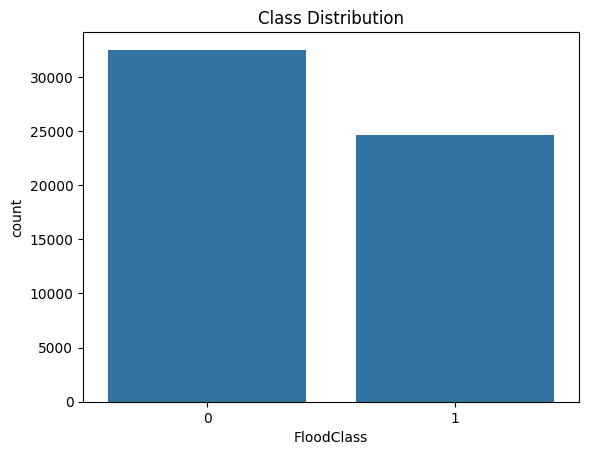

In [8]:
# Class Balance
sns.countplot(x=df['FloodClass'])
plt.title("Class Distribution")
plt.show()

X = df.drop(columns=["FloodProbability", "FloodClass"])
y = df['FloodClass']

In [9]:
# SCALING & SPLITTING


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42)

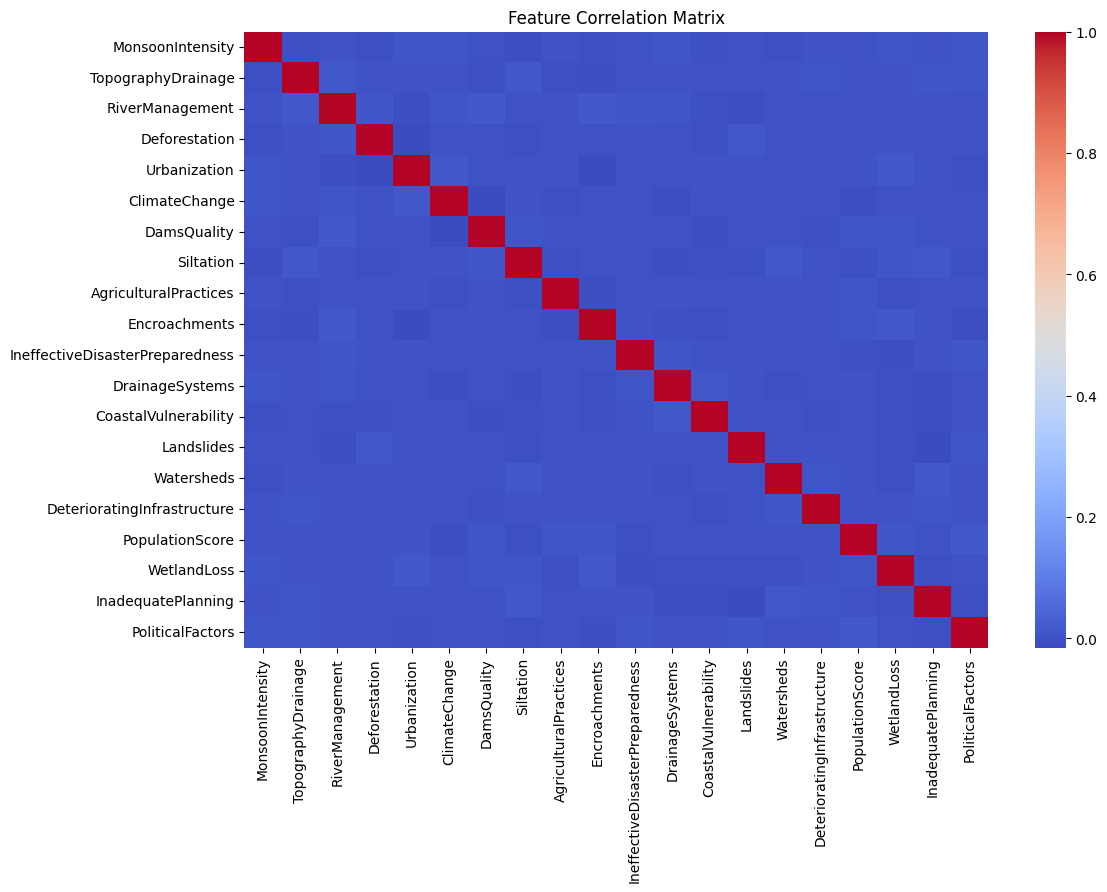

In [10]:
# Feature Correlation Matrix


corr_matrix = pd.DataFrame(X_scaled, columns=X.columns).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

In [11]:
# CPU MODEL (TF)


model_cpu = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_cpu.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

with tf.device('/CPU:0'):
    model_cpu = Sequential([
        Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_cpu.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    start = time.time()
    history_cpu = model_cpu.fit(
        X_train, y_train, epochs=10, batch_size=256, validation_split=0.2, verbose=0)
    cpu_time = time.time() - start


    cpu_loss, cpu_acc = model_cpu.evaluate(X_test, y_test)

print(f" CPU Accuracy: {cpu_acc:.4f} | Time: {cpu_time:.2f} sec")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


536/536 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8466 - loss: 0.3294
 CPU Accuracy: 0.8461 | Time: 7.72 sec


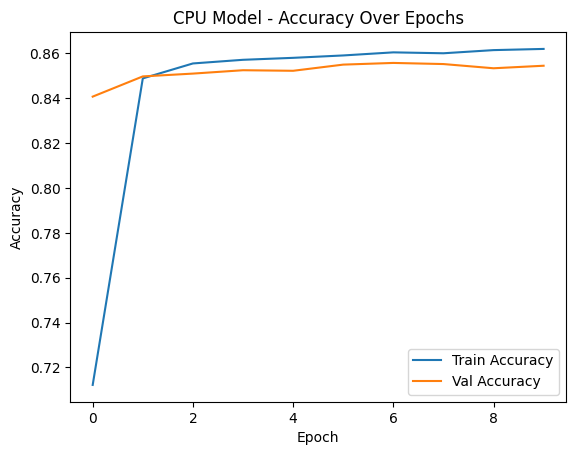

In [12]:
# Accuracy Plot
plt.plot(history_cpu.history['accuracy'], label='Train Accuracy')
plt.plot(history_cpu.history['val_accuracy'], label='Val Accuracy')
plt.title('CPU Model - Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

536/536 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

CPU Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      9750
           1       0.83      0.82      0.82      7383

    accuracy                           0.85     17133
   macro avg       0.84      0.84      0.84     17133
weighted avg       0.85      0.85      0.85     17133



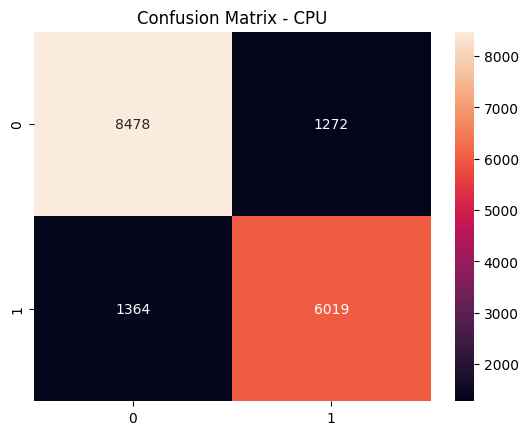

In [14]:
# CONFUSION MATRIX & REPORT

with tf.device('/CPU:0'):
    y_pred_cpu = (model_cpu.predict(X_test) > 0.5).astype(int)

print("\nCPU Classification Report:")
print(classification_report(y_test, y_pred_cpu))

sns.heatmap(confusion_matrix(y_test, y_pred_cpu), annot=True, fmt='d')
plt.title("Confusion Matrix - CPU")
plt.savefig("confusion_matrix_cpu.png")
plt.show()

536/536 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


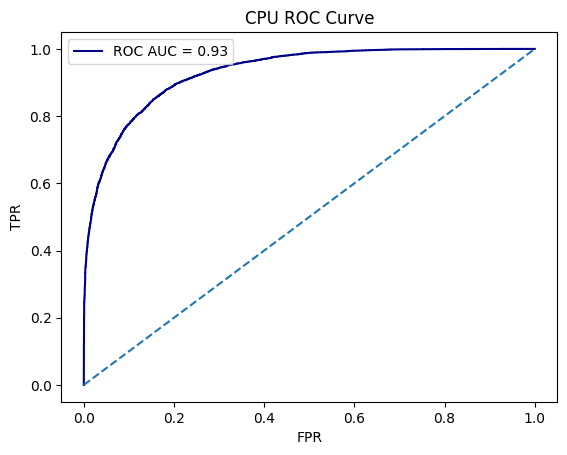

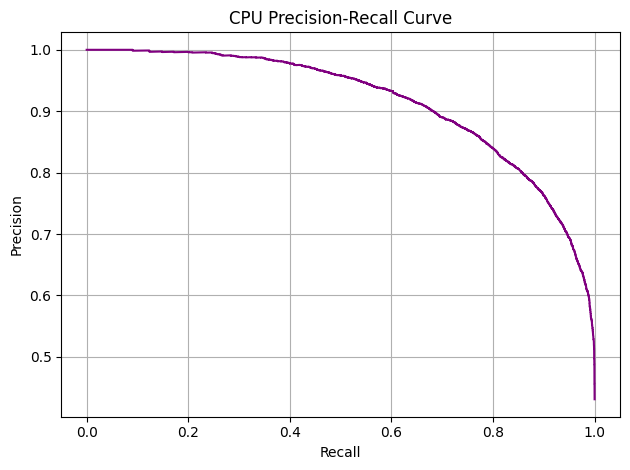

In [15]:
# ROC & PR CURVES - CPU

with tf.device('/CPU:0'):
  proba_cpu = model_cpu.predict(X_test).ravel()

fpr, tpr, _ = roc_curve(y_test, proba_cpu)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}", color='darkblue')
plt.plot([0,1],[0,1],'--')
plt.title("CPU ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test, proba_cpu)
plt.plot(recall, precision, color='purple')
plt.title("CPU Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Batch Size (CPU)


for batch in [256, 450]:
    print(f"\nBatch Size: {batch}")

    with tf.device('/CPU:0'):
        model_exp = Sequential([
            Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
            Dense(16, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        model_exp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Training
        start = time.time()
        model_exp.fit(X_train, y_train, epochs=5, batch_size=batch, verbose=0)
        print(f"Training Time (CPU): {time.time() - start:.2f} sec")

        # Inference latency
        sample = X_test[:1]
        start = time.time()
        _ = model_exp.predict(sample)
        print(f"Inference Latency: {(time.time() - start)*1000:.2f} ms")


Batch Size: 256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Time (CPU): 4.64 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Inference Latency: 123.65 ms

Batch Size: 450
Training Time (CPU): 2.50 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Inference Latency: 116.57 ms
